# Similarity Detection in English Language Using RoBERTa

## Task 1: Import Libraries

In [11]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


## Task 2: Load and Preprocess the Data

In [2]:
data = []

for i in range(100):
    original = open("/usercode/Dataset/" + str(i+1) + "-original.txt", 'r')
    original_text = original.read()

    paraphrase = open("/usercode/Dataset/" + str(i+1) + "-paraphrase.txt", 'r')
    paraphrase_text = paraphrase.read()
    
    with open('/usercode/Dataset/' + str(i + 1) + '-metadata.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(":")
            if key == "Paraphrase":
                verdict = value.strip()

    sample = [original_text, paraphrase_text, verdict]
    data.append([s.replace('\n', ' ') for s in sample])

df = pd.DataFrame(np.array(data), columns = ["source", "target", "label"])
df['label'] = df['label'].map({'Yes': 1, 'No': 1})


## Task 3: Split the Dataset

In [3]:
train_df = df[:60]
val_df = df[60:80]
test_df = df[80:]

## Task 4: Tokenize Datasets

In [4]:
tokenizer = AutoTokenizer.from_pretrained('roberta-similarity')
train_encodings = tokenizer(train_df['source'].tolist(), train_df['target'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['source'].tolist(), val_df['target'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['source'].tolist(), test_df['target'].tolist(), truncation=True, padding=True)

## Task 5: Generate Tensors

In [5]:
class ParaphraseDataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)


train_dataset = ParaphraseDataset(train_encodings, train_df["label"].tolist())
val_dataset = ParaphraseDataset(val_encodings, val_df["label"].tolist())
test_dataset = ParaphraseDataset(test_encodings, test_df["label"].tolist())

## Task 6: Load Pretrained RoBERTa Model and Set Device

## Task 7: Prepare Training Arguments and Create Trainer Object

In [7]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=0,
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=3,
    load_best_model_at_end=True
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([item['input_ids'] for item in data]),
                                'attention_mask': torch.stack([item['attention_mask'] for item in data]),
                                'labels': torch.tensor([item['labels'] for item in data])},
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1))}

)

## Task 8: Train the Model

In [8]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
10,0.120700,0.000487,1.000000
20,0.000700,0.000282,1.000000


TrainOutput(global_step=20, training_loss=0.06070263013243675, metrics={'train_runtime': 420.9102, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.048, 'total_flos': 24974994708000.0, 'train_loss': 0.06070263013243675, 'epoch': 5.0})

## Task 9: Test the Model and Calculate Accuracy

In [9]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = test_df['label'].tolist()

print('Accuracy: ', accuracy_score(true_labels, predicted_labels))

Accuracy:  1.0


## Task 10: Compute and Display the Confusion Matrix

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

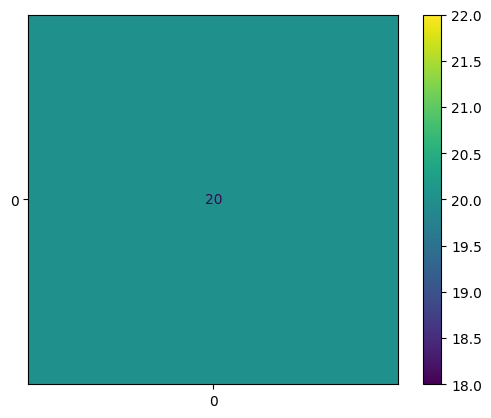

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()